# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as spy
import copy
import math
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

---

# Data ingestion 

In [3]:
data = pd.read_csv("cleaned_used_cars_data.csv")

---

# Univariate Analysis

## Numerical Variables

**List of numerical variables**

In [4]:
num_var= data.select_dtypes(include=np.number).columns.to_list()
print(num_var)

['car_age', 'engine', 'kilometers_driven', 'mileage', 'power', 'price', 'seats', 'year']


**Histogram Overview**

In [5]:
def histogram_overview(data):
    """
    Histogram Overview function
    
    This function below generates a subplots of  `histogram plots` & 
    showing the `distribution of the numerical varible input`
    
    * Generates subplots for each numerical variable in a three column structure.
    * The function takes the Pandas dataframe as the input
    * The function selects the numerical variables from the applied dataframe.
    * It generates a vertical `line` to indicate the `mean`, `median` and `mode` on the histogram
    * `sns.set_style` - sets the Seaborn theme
    * `subplot_nrows` - calculated number of subplot rows
    * `subplot_ncols` - configures the three column structure subplots
    * `figsize` - indicates the size of the plot
    * `sns.reset_defaults()` - resets Seaborn themes and settings to default
    
    """
    num_vars = data.select_dtypes(include=np.number).columns.to_list()
    plt.figure(figsize=(10, 10))
    for i in range(len(num_vars)):
        # Set seaborn theme
        sns.set_style("darkgrid")
        # Subplot no of columns
        subplot_ncols = math.ceil(np.sqrt(len(num_vars)))
        # Subplot no of rows
        subplot_nrows = subplot_ncols

        plt.subplot(subplot_nrows, subplot_ncols, i + 1)

        plt.hist(data[num_vars[i]])
        #Plot vertical line for the mean
        plt.axvline(data[num_vars[i]].mean(),
                    color='green',
                    linestyle='--',
                    label="mean")
        #Plot vertical line for the median
        plt.axvline(data[num_vars[i]].median(),
                    color='red',
                    linestyle='-',
                    label="median")
        #Plot vertical line for the mode
        plt.axvline(data[num_vars[i]].mode()[0],
                    color='black',
                    linestyle='-',
                    label="mode")
        plt.legend()
        plt.tight_layout()
        plt.title(num_vars[i], fontsize=16)
    plt.show()
    # Reset seaborn theme
    sns.reset_defaults()

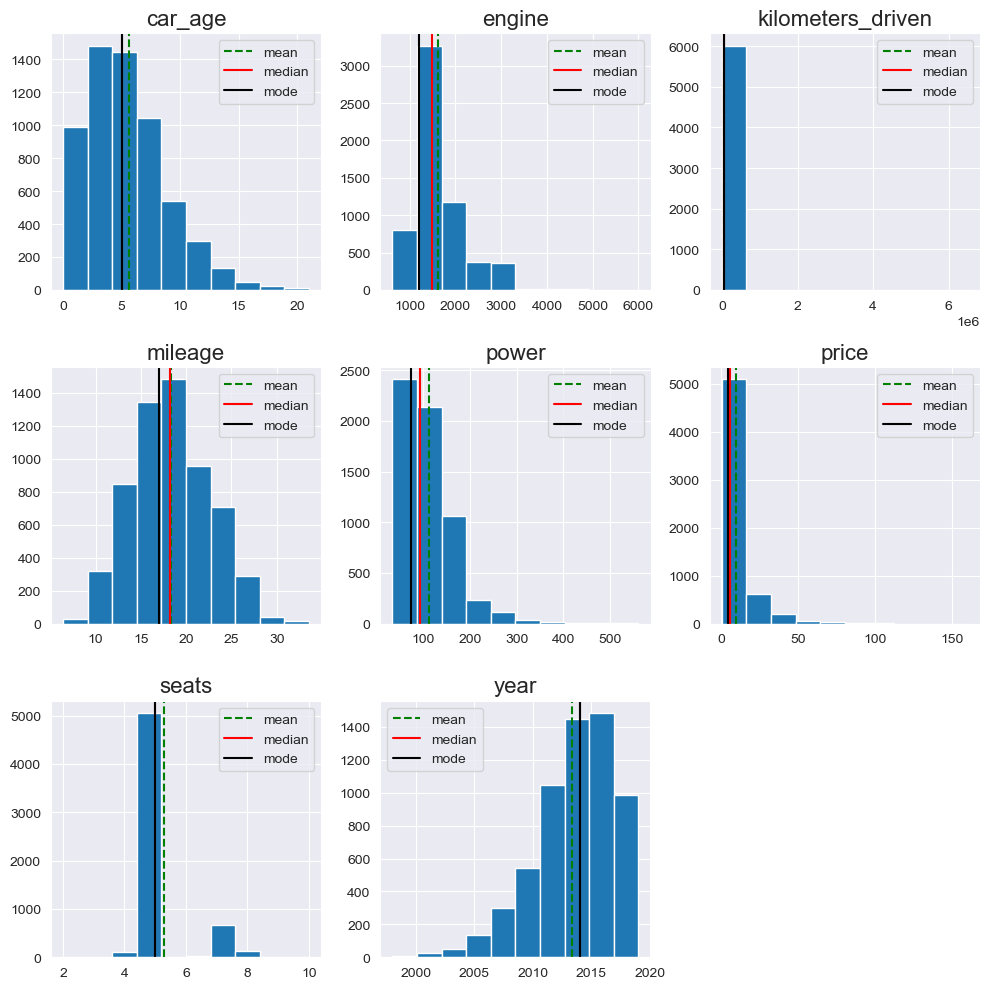

In [6]:
histogram_overview(data)

**Observation:**
* **car_age** - Right skewed as majority of the used cars less than 10 years old. 
* **engine**  - Right skewed as there some cars with large engines.
* **kilometers_driven** is highly right skewed. There may be as a result of a few outliers beyond 200,000. These outliers will be dealt with later on.
* **mileage** - Somewhat normally distribited.
* **power** - Right skewed as there are a cars with large engines.
* **price** - Highly right skewed as there may a few used luxury cars for sale.
* **seats**  - There is no clear distribution as seats are ordinal numerical variables. Majority of the cars have 5 seats.
* **year** -  Left skewed as the majority of the used cars were manufactured from 2010.

**Boxplot overview**

In [7]:
def boxplot_overview(data):
    """
    This function below generates a subplots of `box plots` &
    showing the `distribution of the numerical variable input with outliers`.

    * Generates subplots for each numerical variable in a three column structure.
    * The function takes the Pandas dataframe as the input
    * The function selects the numerical variables from the applied dataframe.
    * It shows the `mean` in the boxplot.
    * `sns.set_style` - sets the Seaborn theme
    * `subplot_nrows` - calculated number of subplot rows
    * `subplot_ncols` - configures the three column structure subplots
    * `figsize` - indicates the size of the plot
    * `sns.reset_defaults()` - resets Seaborn themes and settings to default
    """

    num_vars = data.select_dtypes(include=np.number).columns.to_list()
    plt.figure(figsize=(10, 10))
    for i in range(len(num_vars)):
        # Set seaborn theme
        sns.set_style("darkgrid")
        # Subplot no of columns
        subplot_ncols = math.ceil(np.sqrt(len(num_vars)) )  
        # Subplot no of rows
        subplot_nrows = math.ceil(len(num_vars) / subplot_ncols)  
          
        plt.subplot(subplot_nrows, subplot_ncols, i + 1)
        sns.boxplot(y=data[num_vars[i]], width=0.3, showmeans=True)
        plt.tight_layout()
        plt.title(num_vars[i], fontsize=16)
    plt.show()
    # Reset seaborn theme
    sns.reset_defaults()

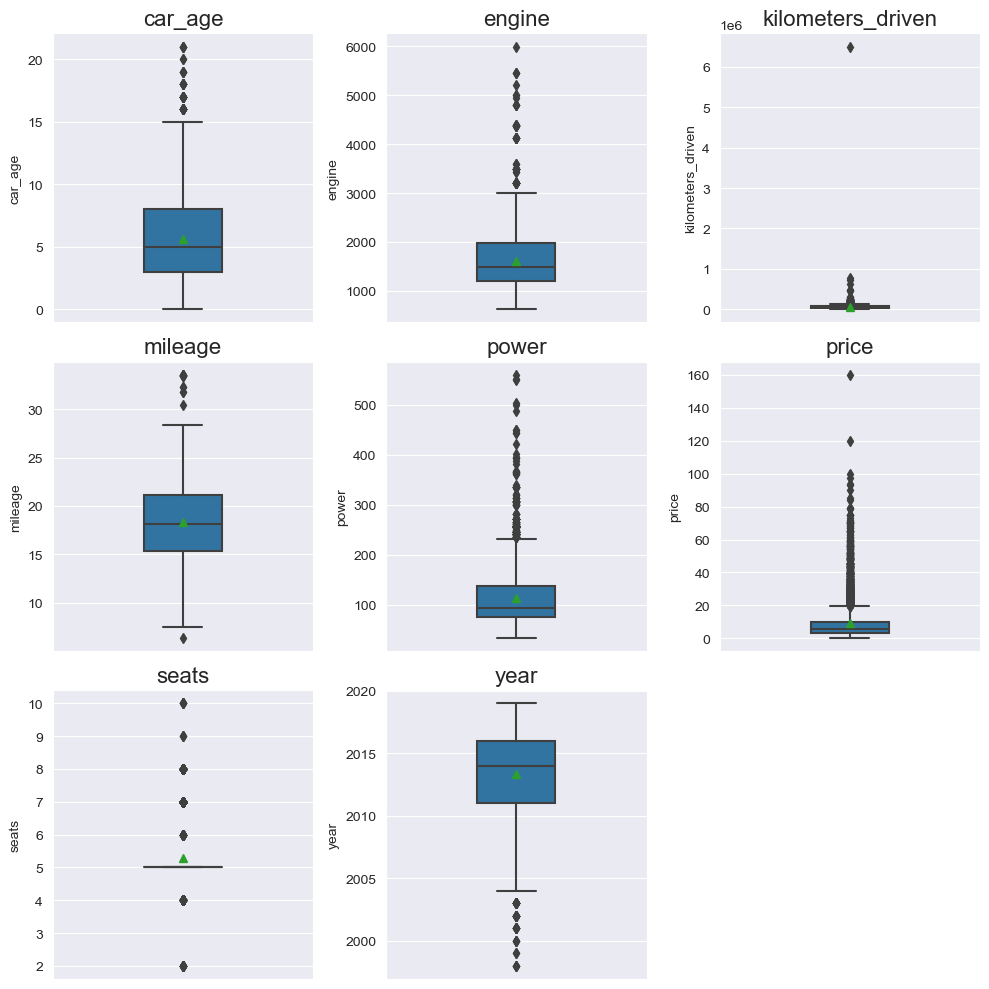

In [8]:
boxplot_overview(data)

**Observation:**
* There are significant amount of upper outliers is the **engine**,**kilometers_driven**, **power** and **price** variables.
* **kilometers_driven** - There are many outliers but there a few significantly large ones skewing the data.
* **seats**  - Since seats is discete numerical variable there are outliers around the medin.
* **year** -  There are lot of lower outliers.

---

**Outlier check function**

In [9]:
# Outlier check
def outlier_count(data):
    """
    This function checks the lower and upper 
    outliers for all numerical variables.

    Outliers are found where data points exists either:
    - Greater than `1.5*IQR` above the 75th percentile
    - Less than `1.5*IQR` below the 25th percentile
    """
    numeric = data.select_dtypes(include=np.number).columns.to_list()
    for i in numeric:
        # Get name of series
        name = data[i].name
        # Calculate the IQR for all values and omit NaNs
        IQR = spy.stats.iqr(data[i], nan_policy="omit")
        # Calculate the boxplot upper fence
        upper_fence = data[i].quantile(0.75) + 1.5 * IQR
        # Calculate the boxplot lower fence
        lower_fence = data[i].quantile(0.25) - 1.5 * IQR
        # Calculate the count of outliers above upper fence
        upper_outliers = data[i][data[i] > upper_fence].count()
        # Calculate the count of outliers below lower fence
        lower_outliers = data[i][data[i] < lower_fence].count()
        # Check if there are no outliers
        if (upper_outliers == 0) & (lower_outliers == 0):
            continue
        print(
            f"The '{name}' distribution has '{lower_outliers}' lower outliers and '{upper_outliers}' upper outliers.\n"
        )

In [10]:
#Applying the Outlier check function
outlier_count(data)

The 'car_age' distribution has '0' lower outliers and '50' upper outliers.

The 'engine' distribution has '0' lower outliers and '61' upper outliers.

The 'kilometers_driven' distribution has '0' lower outliers and '202' upper outliers.

The 'mileage' distribution has '1' lower outliers and '14' upper outliers.

The 'power' distribution has '0' lower outliers and '238' upper outliers.

The 'price' distribution has '0' lower outliers and '718' upper outliers.

The 'seats' distribution has '115' lower outliers and '848' upper outliers.

The 'year' distribution has '50' lower outliers and '0' upper outliers.



---

**Skew Summary**

In [11]:
# Display the skew summary for the numerical variables
for var in data.select_dtypes(include=np.number).columns.to_list():
    var_skew = data[var].skew()
    if var_skew > 1:
        print(f"The '{var}' distribution is highly right skewed.\n")
    elif var_skew < -1:
        print(f"The '{var}' distribution is highly left skewed.\n")
    elif (var_skew > 0.5) & (var_skew < 1):
        print(f"The '{var}' distribution is moderately right skewed.\n")
    elif (var_skew < -0.5) & (var_skew > -1):
        print(f"The '{var}' distribution is moderately left skewed.\n")
    else:
        print(f"The '{var}' distribution is fairly symmetrical.\n")

The 'car_age' distribution is moderately right skewed.

The 'engine' distribution is highly right skewed.

The 'kilometers_driven' distribution is highly right skewed.

The 'mileage' distribution is fairly symmetrical.

The 'power' distribution is highly right skewed.

The 'price' distribution is highly right skewed.

The 'seats' distribution is highly right skewed.

The 'year' distribution is moderately left skewed.



### Correlation Analysis

Let's check to see to see if there are correlations between the numerical variables.

From above we have defined a `num_var` as a list of numerical variables.  
Let's use this list to generate a sub dataframe for correlation analysis.  
We shall use the `filter()` function as it can retrieve columns based on the column names.

In [12]:
num_df = data.filter(num_var)
num_df.head()

,car_age,engine,kilometers_driven,mileage,power,price,seats,year
0,16,1489.0,80000,12.80,35.5,1.35,5.0,2003
1,5,1968.0,79271,20.38,143.0,16.50,5.0,2014
2,2,1968.0,22000,20.38,143.0,22.50,5.0,2017
3,3,1968.0,20003,20.38,143.0,19.25,5.0,2016
4,3,1968.0,39000,20.38,143.0,18.90,5.0,2016


Let's drop `year` column since it is a temporal varible.

In [13]:
num_df = num_df.drop(columns='year')

**Heat Map**

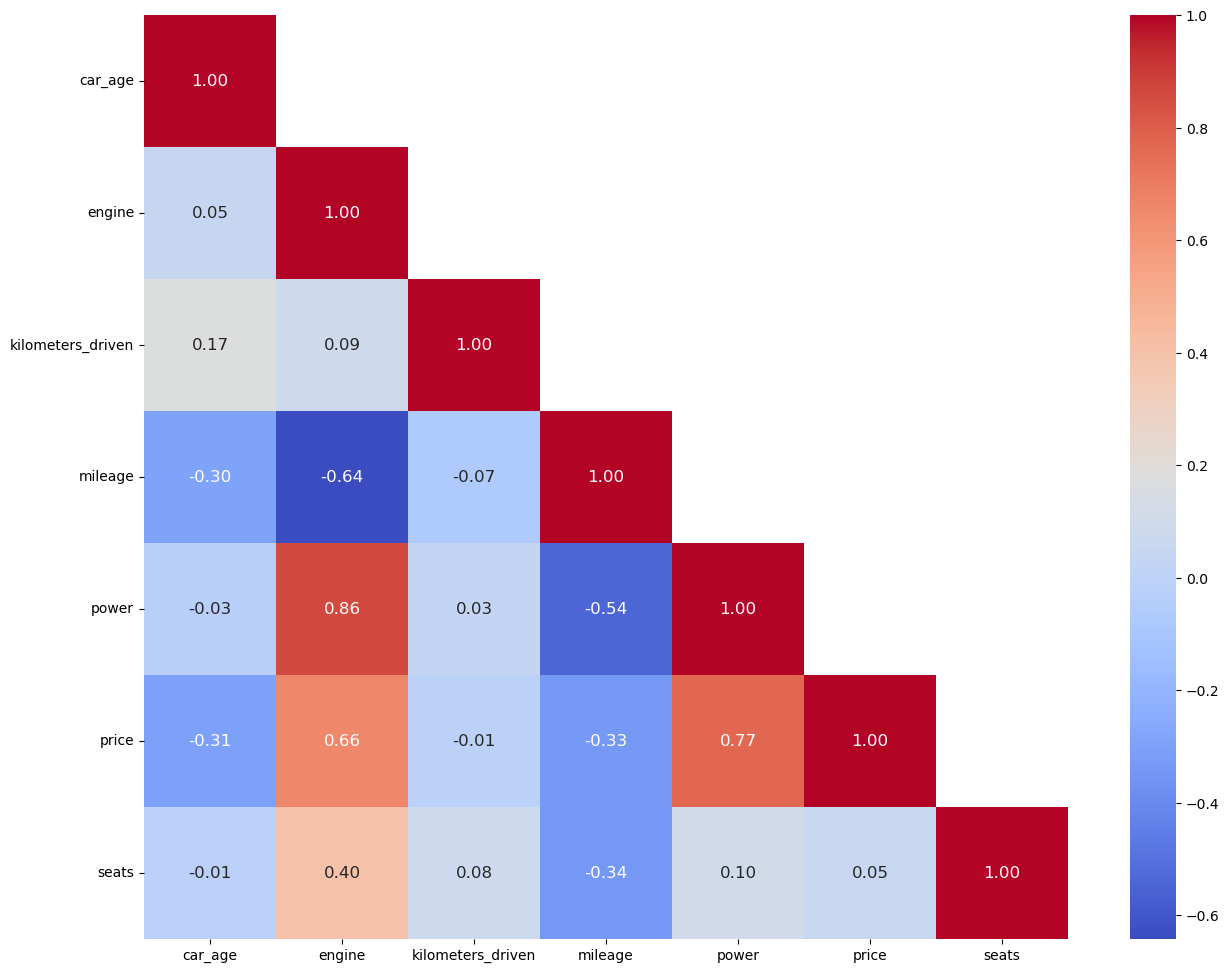

In [14]:
oh_corr = num_df.corr()

annot_kws = {"fontsize": 12}

symmetric_matrix = (oh_corr + oh_corr.T) / 2

# Create a mask for the upper half of the matrix
mask = np.triu(np.ones_like(symmetric_matrix), k=1)

plt.figure(figsize=(16, 12))
sns.heatmap(oh_corr, annot=True, fmt=".2f", mask=mask,
            cmap='coolwarm', square=True, annot_kws=annot_kws)
plt.yticks(rotation=0)
plt.show()

---

## Categorical Variables

**List of categorical variables**

In [15]:
cat_var = data.select_dtypes(exclude=np.number).columns.to_list()
print(cat_var)

['car_name', 'car_make', 'car_model', 'car_spec', 'fuel_type', 'location', 'mileage_unit', 'owner_type', 'region', 'transmission']


During Missing Value treatment, rows were dropped that contained categorical values.  
In the case where all instances of a categorical state being dropped, the dataframe will still contain the state identities which will produce a value count of 0.  
To deal with this we shall check through all categorical variables and remove unused categories.

In [16]:
for var in cat_var:
    if any(data[var].value_counts()==0):
        data[var] = data[var].cat.remove_unused_categories()

Now let's check the number of states each categorical variable has to determine how we explore them.

In [17]:
# Check the unique values
data[cat_var].nunique().to_frame().T

,car_name,car_make,car_model,car_spec,fuel_type,location,mileage_unit,owner_type,region,transmission
0,213,30,209,1703,4,11,2,4,4,2


Since many of the categorical variables have more than 3 states, then we shall use the `bar chart` as it more suitable compared to a `pie chart`.

---

We shall use bar chart to represent the categorical variables.

In [18]:
def bar_chart(data):
    """
    This function below generates a `bar chart` showing
    the `distribution of the categorical varible input`.
    * The function also `generates an image file` of the plot.
    * The function takes the Pandas series as the input.
    * It `computes the frequency of each unique element` and 
      displays the distribution of the elements to in horizontal bars.
    * The `percentage of each bar` is also calculated and placed to 
      the right end of each bar.
    * `sns.despine()` - removes the upper and right border of the chart
    * For each horizontal bar the width is calculated as a percentage of
      the entire quanta of datapoints.
    * The percentage is annotated to the each bar by plotting the cardinal locations.

    """

    # Create a horizontal count plot while sorting variables in descending order
    g = sns.countplot(y=data, order = data.astype(str).value_counts().index)
    # Remove the top and right spines from plot
    sns.despine()
    # length of the column
    col_length = len(data)
    for p in g.patches:
        # percentage of each class of the category
        percentage = '{:.1f}%'.format(100 * p.get_width()/col_length)
        # width of the plot
        x = p.get_x() + p.get_width() + 0.02
        # height of the plot
        y = p.get_y() + p.get_height()/2
        # annotate the percentage
        g.annotate(percentage, (x, y), size=12)
        plt.title("Distribution of {}".format(
            data.name), loc="center", fontsize=22)
    plt.show()
    # Line separator
#     print('--'*55)

---

**Car Name Distribution**

Since car_name has 213 states let's show the top 10

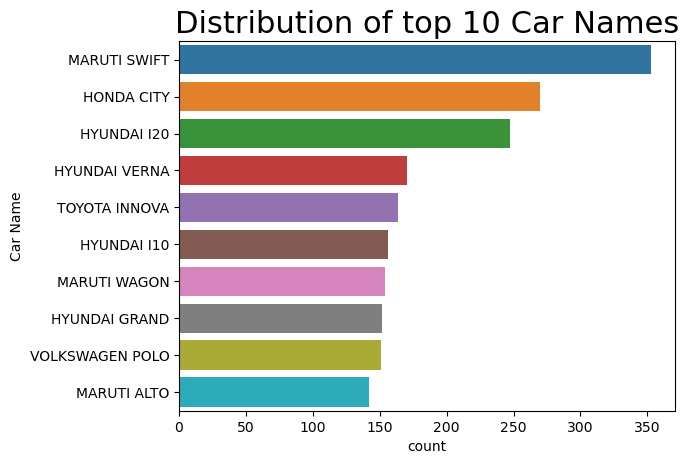

In [19]:
top10_car_name = data.car_name.value_counts().nlargest(10)
sns.barplot(y = top10_car_name.index, x = top10_car_name)
plt.ylabel('Car Name')
plt.title("Distribution of top 10 Car Names",fontsize = 22)
plt.show()

**Observation:**
* `MARUTI SWIFT` is the most popular car while `MARUTI ALTO` is the 10th most popular.

---

**Car_make Distribution**

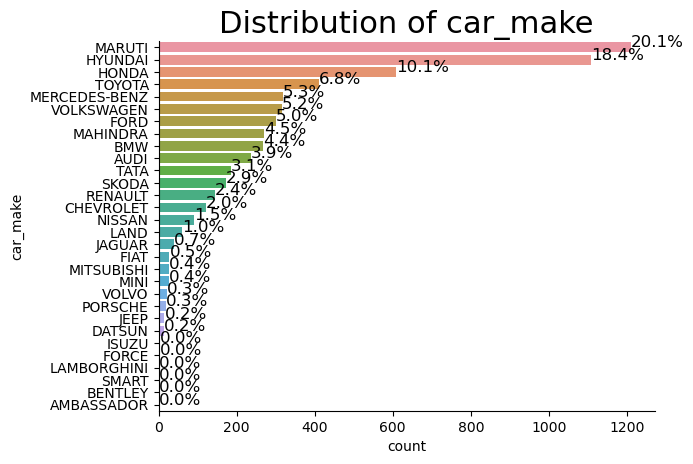

In [20]:
bar_chart(data.car_make)

**Observation:**
* `MARUTI` is the most popular car while `BENTLEY` is the least popular.

**Car Make by Price**

In [21]:
data.groupby(["car_make"])["price"].mean().sort_values(ascending=False)

car_make
LAMBORGHINI      120.000000
BENTLEY           59.000000
PORSCHE           48.348333
LAND              39.259500
JAGUAR            37.632250
MINI              26.896923
MERCEDES-BENZ     26.809874
AUDI              25.537712
BMW               25.243146
VOLVO             18.802857
JEEP              18.718667
ISUZU             14.696667
TOYOTA            11.577171
MITSUBISHI        11.058889
FORCE              9.333333
MAHINDRA           8.027638
SKODA              7.559075
FORD               6.889400
RENAULT            5.799034
HONDA              5.411743
HYUNDAI            5.343433
VOLKSWAGEN         5.307270
NISSAN             4.738352
MARUTI             4.519554
TATA               3.562849
FIAT               3.269286
DATSUN             3.049231
CHEVROLET          3.044463
SMART              3.000000
AMBASSADOR         1.350000
Name: price, dtype: float64

The output is very close to our expectation (domain knowledge), in terms of brand ordering. 

Mean price of a used Lamborghini is 120 Lakhs and that of cars from other luxury brands follow in a descending order.

Towards the bottom end we have the more budget friendly brands.

**Binning cars in categories based on price**

In [22]:
price_ranges = [0.0, 10.0, 20.0, 50.0, float('inf')]
price_labels = ["Budget_Friendly", "Mid-Range", "Luxury_Cars", "Ultra_Luxury"]

# Create a new column "Price_Category" by binning the "Price" variable
data['car_category'] = pd.cut(data['price'], bins=price_ranges, labels=price_labels, right=False)


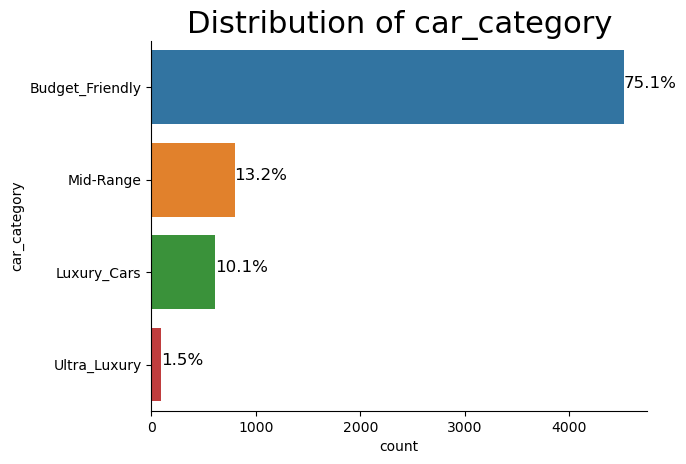

In [23]:
bar_chart(data.car_category)

---

**Fuel_type Distribution**

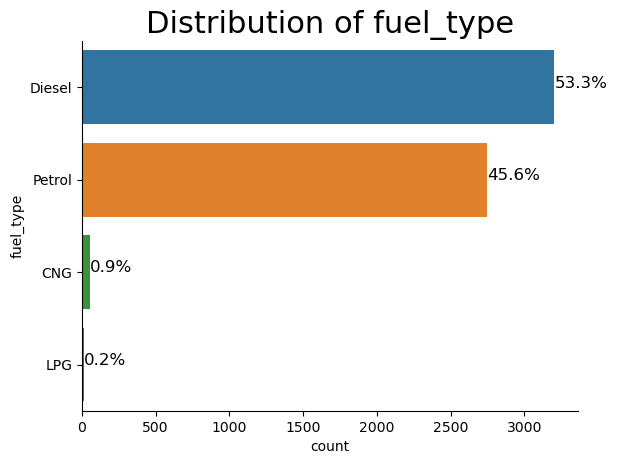

In [24]:
bar_chart(data.fuel_type)

**Observation:**
* `Diesel` is the most popular fuel type.  
* `Diesel` and `Petrol` cars comprise the majority of the dataset (~98.9%).  
In further analysis we shall only consider cars of `Diesel` and `Petrol` fuel types.

---

**Location Distribution**

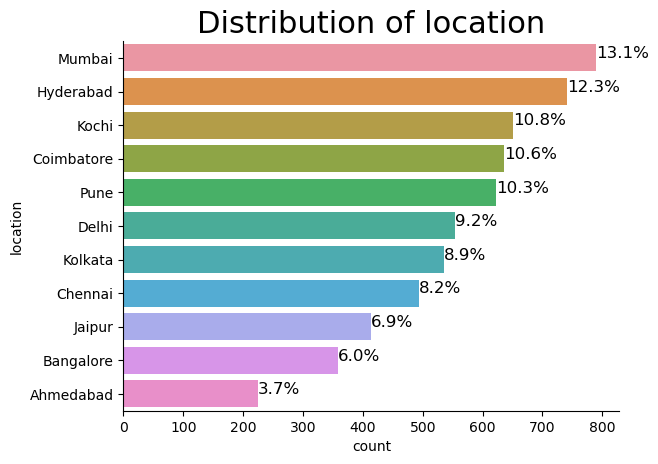

In [25]:
bar_chart(data.location)

**Observation:**
* `Mumbai` has the most amount of used cars for sale while `Ahmedabad` has the least.

**Region Distribution**

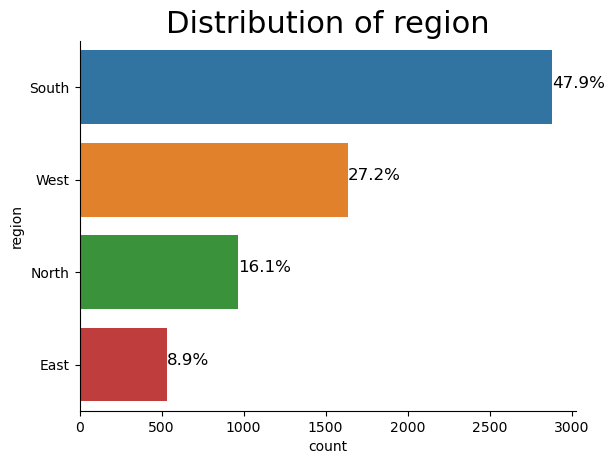

In [26]:
bar_chart(data.region)

---

**Mileage_unit Distribution**

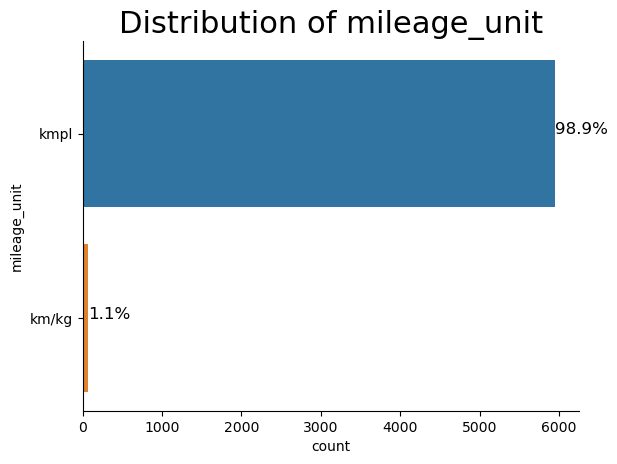

In [27]:
bar_chart(data.mileage_unit)

**Observation:**
* `kmpl` is the most popular unit of mileage (~99%).  
We shall explore which cars use km/kg as its mileage unit later.

---

**Owner_type Distribution**

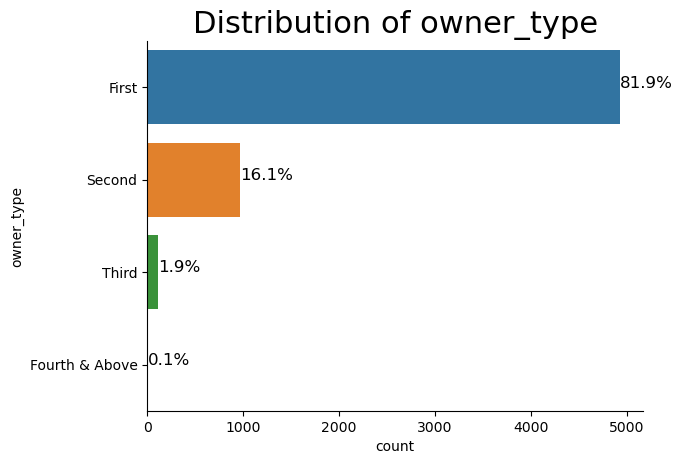

In [28]:
bar_chart(data.owner_type)

**Observation:**
* The majority of the used cars are either `First` and `Second` owner types. These account for ~98%.  
In further analysis we shall only consider cars of First` and `Second` owner types. 

---

**Transmission Distribution**

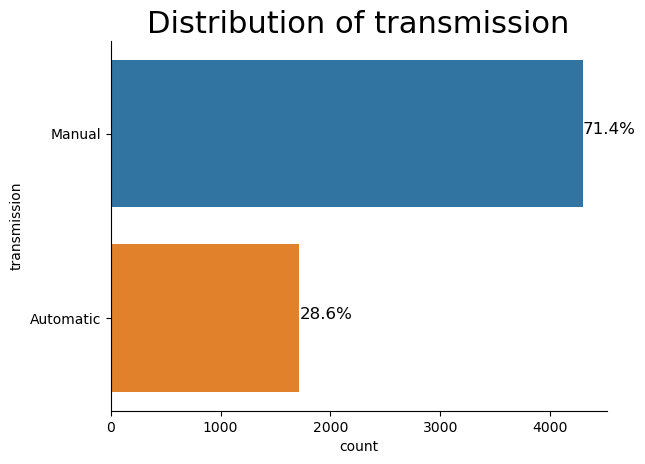

In [29]:
bar_chart(data.transmission)

**Observation:**
* The majority of the cars in the dataset are `Manual` transmission.

---

---

In [32]:
data.to_csv('dataprep_used_cars_data.csv', index=False)